### Import libraries

In [207]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from IPython.display import HTML, display, SVG
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot

import math
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

import nltk
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

In [208]:
seed = 13
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

In [209]:
SOURCE_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'Models_and_output/'

In [227]:
train_data = pd.read_csv(SOURCE_FOLDER + 'train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv(SOURCE_FOLDER + 'test.csv', encoding='utf8')
test_data = test_data[test_data.columns[1:-1]]

In [228]:
train_data = train_data[train_data['TRANS_CONV_TEXT'].notnull()]

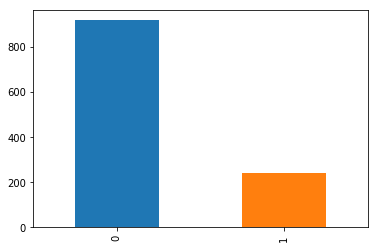

In [230]:
train_data.Patient_Tag.value_counts().plot('bar')

In [231]:
X_train = train_data['TRANS_CONV_TEXT']
Y_train = train_data['Patient_Tag']
Y_train = to_categorical(Y_train)

In [233]:
def preprocess_data(X_train, stemmer, lemma):
    preprocessed_data = []
    trans = str.maketrans('/(){}', ' ' * 5)
    trans_punc = str.maketrans('', '', string.punctuation)

    for text in X_train:
        text = text.lower().translate(trans)
        text = text.translate(trans_punc)
        text = [lemma.lemmatize(word) for word in text.split()]
        preprocessed_data.append(' '.join(text))

    return preprocessed_data

In [234]:
preprocessed_data = preprocess_data(X_train, stemmer, lemma)

In [235]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 3))
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [236]:
X_train = vectorizer.transform(X_train).toarray()
X_train.shape

(1156, 1000)

In [237]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed)

In [238]:
X_train.shape

(774, 1000)

In [239]:
X_valid.shape

(382, 1000)

In [240]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [241]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [242]:
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(128, activation='relu'))
model.add(Dense(2,
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.4)))

In [243]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

model.compile(optimizer=custom_adam,
              loss='categorical_crossentropy',
              metrics=[auc_pr, 'accuracy'])

model.fit_generator(generator=batch_generator_shuffle(X_train, y_train, 32),
                      epochs=200, validation_data=(X_valid, y_valid),
                      steps_per_epoch=X_train.shape[0] / 32)

scores = model.evaluate(X_valid, y_valid)
print ('\n')
print (scores)

Epoch 1/200
25/24 [===============================] - 1s 56ms/step - loss: 1.2092 - auc_pr: 0.7923 - acc: 0.7743 - val_loss: 0.5349 - val_auc_pr: 0.8924 - val_acc: 0.7906
Epoch 2/200
25/24 [===============================] - 0s 8ms/step - loss: 0.3200 - auc_pr: 0.9142 - acc: 0.8246 - val_loss: 0.3347 - val_auc_pr: 0.9275 - val_acc: 0.8298
Epoch 3/200
25/24 [===============================] - 0s 8ms/step - loss: 0.1917 - auc_pr: 0.9380 - acc: 0.9675 - val_loss: 0.3565 - val_auc_pr: 0.9463 - val_acc: 0.8482
Epoch 4/200
25/24 [===============================] - 0s 8ms/step - loss: 0.1142 - auc_pr: 0.9534 - acc: 0.9962 - val_loss: 0.3883 - val_auc_pr: 0.9593 - val_acc: 0.8560
Epoch 5/200
25/24 [===============================] - 0s 8ms/step - loss: 0.0646 - auc_pr: 0.9634 - acc: 0.9975 - val_loss: 0.4183 - val_auc_pr: 0.9666 - val_acc: 0.8560
Epoch 6/200
25/24 [===============================] - 0s 8ms/step - loss: 0.0407 - auc_pr: 0.9693 - acc: 0.9987 - val_loss: 0.4460 - val_auc_pr: 0.97

25/24 [===============================] - 0s 8ms/step - loss: 0.0021 - auc_pr: 0.9827 - acc: 1.0000 - val_loss: 0.8258 - val_auc_pr: 0.9826 - val_acc: 0.8377
Epoch 48/200
25/24 [===============================] - 0s 7ms/step - loss: 0.0024 - auc_pr: 0.9826 - acc: 1.0000 - val_loss: 0.6953 - val_auc_pr: 0.9826 - val_acc: 0.8455
Epoch 49/200
25/24 [===============================] - 0s 7ms/step - loss: 0.0021 - auc_pr: 0.9826 - acc: 1.0000 - val_loss: 0.6695 - val_auc_pr: 0.9825 - val_acc: 0.8455
Epoch 50/200
25/24 [===============================] - 0s 13ms/step - loss: 0.0020 - auc_pr: 0.9825 - acc: 1.0000 - val_loss: 0.6059 - val_auc_pr: 0.9825 - val_acc: 0.8560
Epoch 51/200
25/24 [===============================] - 0s 12ms/step - loss: 0.0019 - auc_pr: 0.9825 - acc: 1.0000 - val_loss: 0.5731 - val_auc_pr: 0.9825 - val_acc: 0.8560
Epoch 52/200
25/24 [===============================] - 0s 8ms/step - loss: 0.0018 - auc_pr: 0.9826 - acc: 1.0000 - val_loss: 0.5714 - val_auc_pr: 0.9826 - v

Epoch 95/200
25/24 [===============================] - 0s 12ms/step - loss: 8.7486e-04 - auc_pr: 0.9811 - acc: 1.0000 - val_loss: 0.8888 - val_auc_pr: 0.9811 - val_acc: 0.8534
Epoch 96/200
25/24 [===============================] - 0s 12ms/step - loss: 8.7643e-04 - auc_pr: 0.9810 - acc: 1.0000 - val_loss: 1.0330 - val_auc_pr: 0.9810 - val_acc: 0.8455
Epoch 97/200
25/24 [===============================] - 0s 8ms/step - loss: 0.0019 - auc_pr: 0.9810 - acc: 1.0000 - val_loss: 0.5416 - val_auc_pr: 0.9810 - val_acc: 0.8482
Epoch 98/200
25/24 [===============================] - 0s 7ms/step - loss: 9.8599e-04 - auc_pr: 0.9810 - acc: 1.0000 - val_loss: 0.6276 - val_auc_pr: 0.9810 - val_acc: 0.8455
Epoch 99/200
25/24 [===============================] - 0s 13ms/step - loss: 0.0011 - auc_pr: 0.9811 - acc: 1.0000 - val_loss: 0.5821 - val_auc_pr: 0.9811 - val_acc: 0.8455
Epoch 100/200
25/24 [===============================] - 0s 8ms/step - loss: 8.1370e-04 - auc_pr: 0.9811 - acc: 1.0000 - val_loss: 

25/24 [===============================] - 0s 12ms/step - loss: 4.4290e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0.8423 - val_auc_pr: 0.9799 - val_acc: 0.8534
Epoch 142/200
25/24 [===============================] - 0s 13ms/step - loss: 4.3432e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0.7702 - val_auc_pr: 0.9799 - val_acc: 0.8534
Epoch 143/200
25/24 [===============================] - 0s 11ms/step - loss: 4.2714e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0.8105 - val_auc_pr: 0.9799 - val_acc: 0.8508
Epoch 144/200
25/24 [===============================] - 0s 9ms/step - loss: 4.6316e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0.7584 - val_auc_pr: 0.9799 - val_acc: 0.8508
Epoch 145/200
25/24 [===============================] - 0s 7ms/step - loss: 4.6996e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0.7530 - val_auc_pr: 0.9799 - val_acc: 0.8534
Epoch 146/200
25/24 [===============================] - 0s 9ms/step - loss: 4.7416e-04 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 0

25/24 [===============================] - 0s 7ms/step - loss: 3.0058e-04 - auc_pr: 0.9795 - acc: 1.0000 - val_loss: 0.7121 - val_auc_pr: 0.9795 - val_acc: 0.8534
Epoch 188/200
25/24 [===============================] - 0s 7ms/step - loss: 3.2048e-04 - auc_pr: 0.9795 - acc: 1.0000 - val_loss: 0.8081 - val_auc_pr: 0.9795 - val_acc: 0.8455
Epoch 189/200
25/24 [===============================] - 0s 7ms/step - loss: 3.4054e-04 - auc_pr: 0.9795 - acc: 1.0000 - val_loss: 0.8074 - val_auc_pr: 0.9795 - val_acc: 0.8508
Epoch 190/200
25/24 [===============================] - 0s 7ms/step - loss: 3.2048e-04 - auc_pr: 0.9795 - acc: 1.0000 - val_loss: 1.3393 - val_auc_pr: 0.9795 - val_acc: 0.8455
Epoch 191/200
25/24 [===============================] - 0s 7ms/step - loss: 4.4452e-04 - auc_pr: 0.9794 - acc: 1.0000 - val_loss: 1.0023 - val_auc_pr: 0.9794 - val_acc: 0.8534
Epoch 192/200
25/24 [===============================] - 0s 7ms/step - loss: 5.8000e-04 - auc_pr: 0.9794 - acc: 1.0000 - val_loss: 1.51

7: val_loss: 0.3521 - val_auc_pr: 0.9775 - val_acc: 0.8922
200: val_loss: 0.6366 - val_auc_pr: 0.9851 - val_acc: 0.8889

[0.626494295846403, 0.983139782170065, 0.8856209134743884]

In [244]:
X_test = test_data['TRANS_CONV_TEXT']
X_test = preprocess_data(X_test, stemmer, lemma)
X_test = vectorizer.transform(X_test).toarray()

In [265]:
output = model.predict(X_test, 32)

patient_tag = np.argmax(output, axis=1)
index = list(range(1, len(output)+1))
test_data_df = pd.DataFrame({'Index': index,'Patient_Tag': patient_tag}).set_index('Index')
test_data_df.to_csv('output.csv', columns=['Patient_Tag'] )

In [266]:
test_data_df.Patient_Tag.value_counts()

0    490
1     81
Name: Patient_Tag, dtype: int64

In [260]:
# model_json = model.to_json()
# with open(OUTPUT_FOLDER + "1_model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(OUTPUT_FOLDER + "1_model.h5")